# IAA Laboratori 7 - Explainable Boosting Machines
## 


## Why do we need AI to be interpretable?

- Automated decision-making
- Even for important decisions
- ML research: increase accuracy by .01% of an already super complex model
    - now often extra element: explainability
    - understudied field of research

**intrinsic vs post-hoc**  <br>
Intrinsic machine learning models are intrinsically interpretable. Common examples are decision trees and sparse linear models, where you can purposely restrict the complexity of the model. Post-hoc interpretation is the application of methods to analyse the model after it has been trained. A typical example of post-hoc interpretation is permutation feature importance which is computed for tree-based models.

**model-specific vs model-agnostic**  <br>
Interpretation tools can either be model-specific or model-agnostic. An example of model-specific interpretability are the weights of a regression model. Model-agnostic interpretability methods are not allowed access to the model internals such as the weights or other parameters. These methods solely look at feature inputs and outputs. An example of a model-agnostic interpretation method are partial dependence plots (PDP).

**local vs global**  <br>
Local or global explanations are related to the scope of the explanation. A local explanation means that the interpretation method explain an individuel prediction, whereas a global interpretation method will explain the global model behaviour.

The following will attempt to provide an intuition of fundamental explainable AI methods.

In [57]:
# install interpret if not already installed
try:
    import interpret
except ModuleNotFoundError:
    !pip install --quiet interpret

In [113]:
import os

import pandas as pd
import numpy as np

import statsmodels.api as sm
from sklearn import datasets
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, auc

import seaborn as sns
import matplotlib.pyplot as plt

from interpret.glassbox import  ExplainableBoostingRegressor
from interpret import show
from interpret.perf import RegressionPerf

pd.set_option('display.float_format', '{:.3f}'.format)
sns.set()

In [114]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import display, HTML
show_html = lambda html: display(HTML(html))

from time import time
from datetime import timedelta

init_time = time()

# Hiding warnings 
import warnings
warnings.filterwarnings("ignore")

# Diabetes Progression

We are going to use a simple regression dataset for explaining this seminar. This dataset uses medical and demographic variables from patients to predict its diabetes progression w.r.t. a baseline. 

The diabetes dataset contains measurements taken from 442 diabetic patients:

    10 baseline variables (features):
        age - age in years
        sex - male or female
        bmi - body mass index
        bp - average blood pressure
        s1 - TC: total serum cholesterol
        s2 - LDL: low-density lipoproteins
        s3 - HDL: high-density lipoproteins
        s4 - TCH: total cholesterol / HDL
        s5 - LTG: possibly log of serum triglycerides level
        s6 - GLU: blood sugar level
        
    One target variable: a quantitative measure of disease progression one year after baseline


In [115]:
from sklearn.datasets import load_diabetes

X, y = load_diabetes(return_X_y=True, scaled= False, as_frame=True)
X['sex'] = X['sex'].astype('category')
X.sex.value_counts()

sex
1.0    235
2.0    207
Name: count, dtype: int64

In [116]:
X.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,59.000,2.000,32.100,101.000,157.000,93.200,38.000,4.000,4.860,87.000
1,48.000,1.000,21.600,87.000,183.000,103.200,70.000,3.000,3.892,69.000
2,72.000,2.000,30.500,93.000,156.000,93.600,41.000,4.000,4.673,85.000
3,24.000,1.000,25.300,84.000,198.000,131.400,40.000,5.000,4.890,89.000
4,50.000,1.000,23.000,101.000,192.000,125.400,52.000,4.000,4.290,80.000


In [117]:
variable_names = ['age', 
                  'sex',
                  'bmi',
                  'average blood pressure',
                  'total serum cholesterol',
                  'low-density lipoproteins',
                  'high-density lipoproteins',
                  'total cholesterol / HDL',
                  'log of serum triglycerides level',
                  'blood sugar level']
X.columns = variable_names
#y.columns = ['diabetes']
diabetes = pd.DataFrame(X)
diabetes['diabetes'] = y

seed = 42
np.random.seed(seed)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=seed)
X.head()

,age,sex,bmi,average blood pressure,total serum cholesterol,low-density lipoproteins,high-density lipoproteins,total cholesterol / HDL,log of serum triglycerides level,blood sugar level
0,59.000,2.000,32.100,101.000,157.000,93.200,38.000,4.000,4.860,87.000
1,48.000,1.000,21.600,87.000,183.000,103.200,70.000,3.000,3.892,69.000
2,72.000,2.000,30.500,93.000,156.000,93.600,41.000,4.000,4.673,85.000
3,24.000,1.000,25.300,84.000,198.000,131.400,40.000,5.000,4.890,89.000
4,50.000,1.000,23.000,101.000,192.000,125.400,52.000,4.000,4.290,80.000


In [118]:
diabetes = pd.DataFrame(X, columns=variable_names)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
diabetes['diabetes'] = y



seed = 42
np.random.seed(seed)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=seed)

In [121]:
print(y)

[101  35  92 145  86  55  89  23  66 206  59  29 124 130  72 117 113  95
  55 115  28  11  28 170 129 144  88  43  83 195  82  20 212  45  25  60
 183 190 174  48  58  17  22  50 178  15 134  93  35  93 105 158  20  62
 127  81  14   2 116 116  22  95  14  81  31 111 100  55 108 123  10 185
 144  67  43   5 116 142 174  68  94  13  14 148  25  92  17  85   5  67
  56 112  10  54  48 110 100 192  50  41  81  60 202 140  53  15  85  95
 161  40  62  20 171 201 177 159 189 194 124 142 142 119 125  42  74 109
  57  65  70 184 188 107  63  41  61 186  43 193 211 194  72 208 163  21
 120 178 123  81  54  79 196  46 197  31 139 131   0  42  54 137  15 153
 118  83 150  20  30 155 184 102   9  34 199  59 101  80 165 158  40 101
  63  24  89 130 183  59  88  94  92  38 197 123  49  71  44  75  32  82
  93  48 107   3 138 157 191  57 138 144 105  36 135  30  33  11  25 181
 172 200 150 130  37  51 174 100  36 146  36  64 108  15 155 104 178  48
 171  77  27  32 176 180 189 122  31   9 132  78  3

## Explore the dataset

In [119]:
from interpret import show
from interpret.data import Marginal

marginal = Marginal().explain_data(X_train, y_train, name = 'Train Data')
show(marginal)

<!-- http://127.0.0.1:7026/11040761232/ -->

In [122]:
diabetes.sex.value_counts()

sex
1.0    235
2.0    207
Name: count, dtype: int64

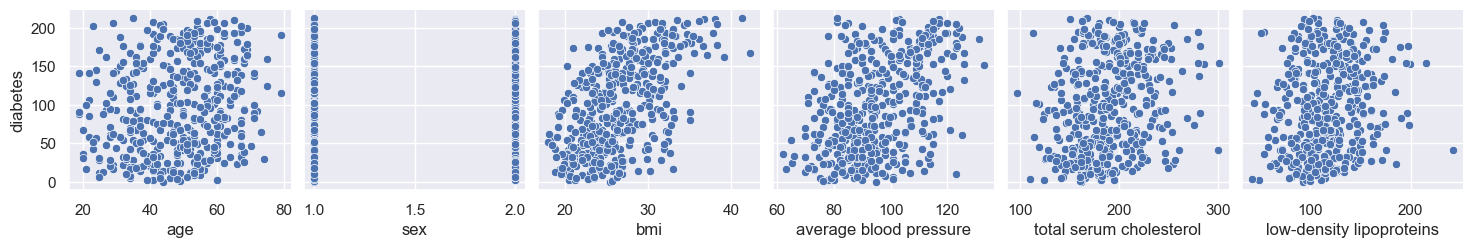

In [66]:
sns.pairplot(diabetes,y_vars=['diabetes'], x_vars = ['age', 'sex', 'bmi', 'average blood pressure',
       'total serum cholesterol', 'low-density lipoproteins']);

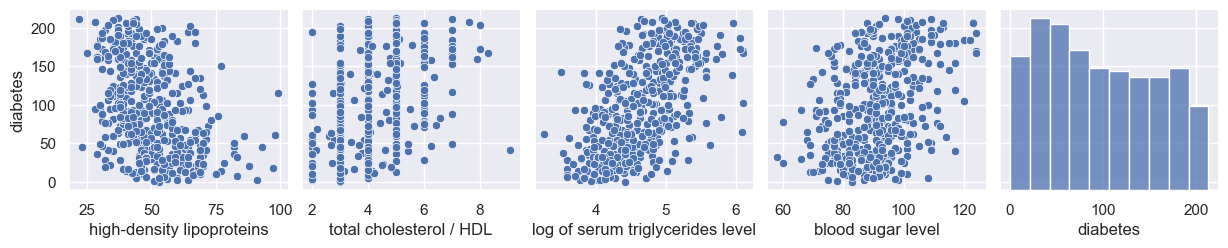

In [67]:
sns.pairplot(diabetes,y_vars=['diabetes'], x_vars = ['high-density lipoproteins', 'total cholesterol / HDL',
       'log of serum triglycerides level', 'blood sugar level', 'diabetes']);

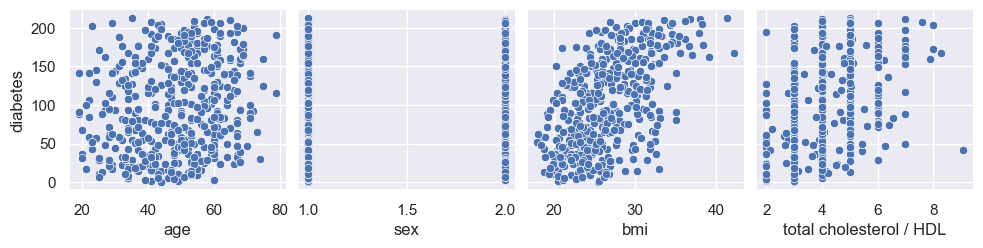

In [68]:
sns.pairplot(diabetes,y_vars=['diabetes'], x_vars = ['age', 'sex', 'bmi', 'total cholesterol / HDL']);

# Linear Regression

$y =  \epsilon + w_0x_0 + w_1x_1  +  \dots + w_nx_n $

Linear regression is one of the most simple an explainable models as you can see the effect to the target of modifying each of the variables independently. 

The main problem with this model is that needs to take into account a set of quite restrictive assumptions.
* Target variable is Gaussian.
* Variables do not interact between them. 
* There is a linear relationship between variables and target.

There are several implementations of linear regression. Most used ones are [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) and [statsmodels](https://www.statsmodels.org/dev/examples/notebooks/generated/ols.html) ones.

In [123]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X,y)

weights = regressor.coef_
intercept=regressor.intercept_
weights, intercept

LinearRegression()

(array([-1.43375218e-02, -1.84428955e+01,  4.06369231e+00,  8.72121148e-01,
        -8.44590824e-01,  6.43106322e-01,  1.35131015e-01,  2.94947385e+00,
         5.60299967e+01,  1.60080635e-01]),
 -272.6818439444397)

<Axes: xlabel='bmi', ylabel='diabetes'>

<Axes: xlabel='bmi', ylabel='bmi'>

Text(0, 0.5, 'bmi * w_2 + inter')

Text(0.5, 1.0, 'w_2=4.063692307058749')

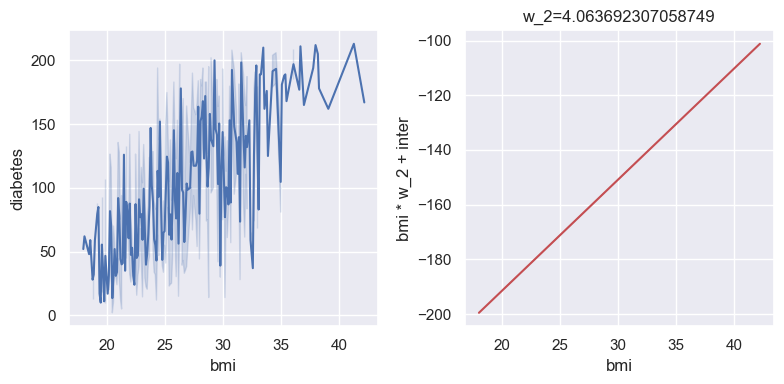

In [124]:
fig, axes = plt.subplots(1,2,figsize=(8,4))
sns.lineplot(x=diabetes['bmi'], y=diabetes['diabetes'],ax=axes[0])
sns.lineplot(x=diabetes['bmi'], y=diabetes['bmi'] * weights[2]+intercept,color='r',ax=axes[1])
axes[1].set_ylabel('bmi * w_2 + inter');
axes[1].set_title(f'w_2={weights[2]}');
fig.set_tight_layout('pad')

In [127]:
regressor.score(X,y)

0.5115831637110331

Even though sklearn is really simple to use, statsmodels returns more information that can be helpful for model interpretation. 

Next table shows: 
* coef: The weights computed by the model. It shows how much effect has the variable in the prediction. 
* std err: The standard error of the weights. It shows how much sure the model is about the weight value. 
* t statistic: The feature importance (weight / std_err(weight)). If the error is big, the feature is less important. 
* p value of t statistic: If variable importance shows statistic significance for the model. 
* [0.025      0.975] The confidence intervals of the weights. 

In [125]:
x = sm.add_constant(X)

#fit linear regression model
model = sm.OLS(y, x,).fit()

#view model summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.512
Model:                            OLS   Adj. R-squared:                  0.500
Method:                 Least Squares   F-statistic:                     45.14
Date:                Mon, 13 Nov 2023   Prob (F-statistic):           5.64e-61
Time:                        12:47:34   Log-Likelihood:                -2277.9
No. Observations:                 442   AIC:                             4578.
Df Residuals:                     431   BIC:                             4623.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

You can also use this library for plotting a partial regression plot. 

This plot shows the relationship between the response and the given explanatory variable after removing the effect of all other explanatory variables.

For doing so, x axis shows the values of the residuals of the prediction of the variable we are checking by using the other variables and y axis the values of the residuals of the original model. 

<Axes: ylabel='Count'>

Text(0.5, 1.0, 'Diabetes - Diabetes_pred')

Text(0.5, 0, 'Residuals(Diabetes)')

<Axes: ylabel='Count'>

Text(0.5, 1.0, 'Age - Age_pred')

Text(0.5, 0, 'Residuals(Age)')

<Axes: >

Text(0.5, 0, 'Residuals(Age)')

Text(0, 0.5, 'Residuals(Diabetes)')

Text(0.5, 1.0, 'Partial Regression Plot')

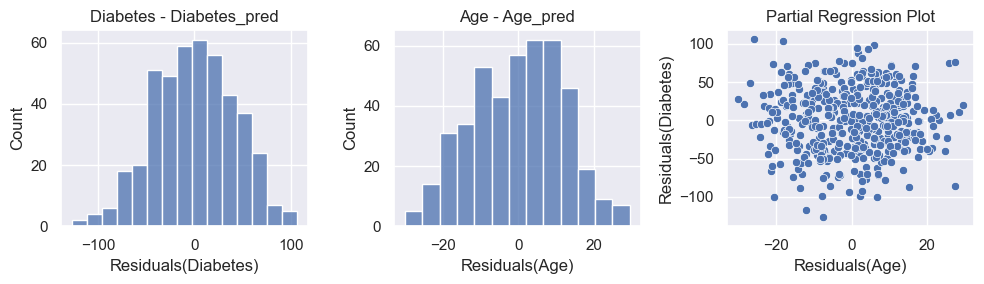

In [126]:
weights = model.params.values
pred =   np.matmul(x.values, weights.T)

residuals = y - pred



age_index = 1

non_age = np.full(x.shape[1], True)
non_age[age_index] = False

age = x.values[:,age_index]
other_variables = x.values[:, non_age]


age_model = sm.OLS(age, other_variables,).fit()
age_residuals = age_model.resid

fig, axes = plt.subplots(1, 3, figsize=(10,3))

sns.histplot(residuals,ax=axes[0]);

axes[0].set_title('Diabetes - Diabetes_pred')
axes[0].set_xlabel('Residuals(Diabetes)')

sns.histplot(age_residuals, ax=axes[1]);
axes[1].set_title('Age - Age_pred')
axes[1].set_xlabel('Residuals(Age)')

sns.scatterplot(y=residuals, x=age_residuals, ax=axes[2]);
axes[2].set_xlabel('Residuals(Age)')
axes[2].set_ylabel('Residuals(Diabetes)')
axes[2].set_title('Partial Regression Plot')

plt.tight_layout()

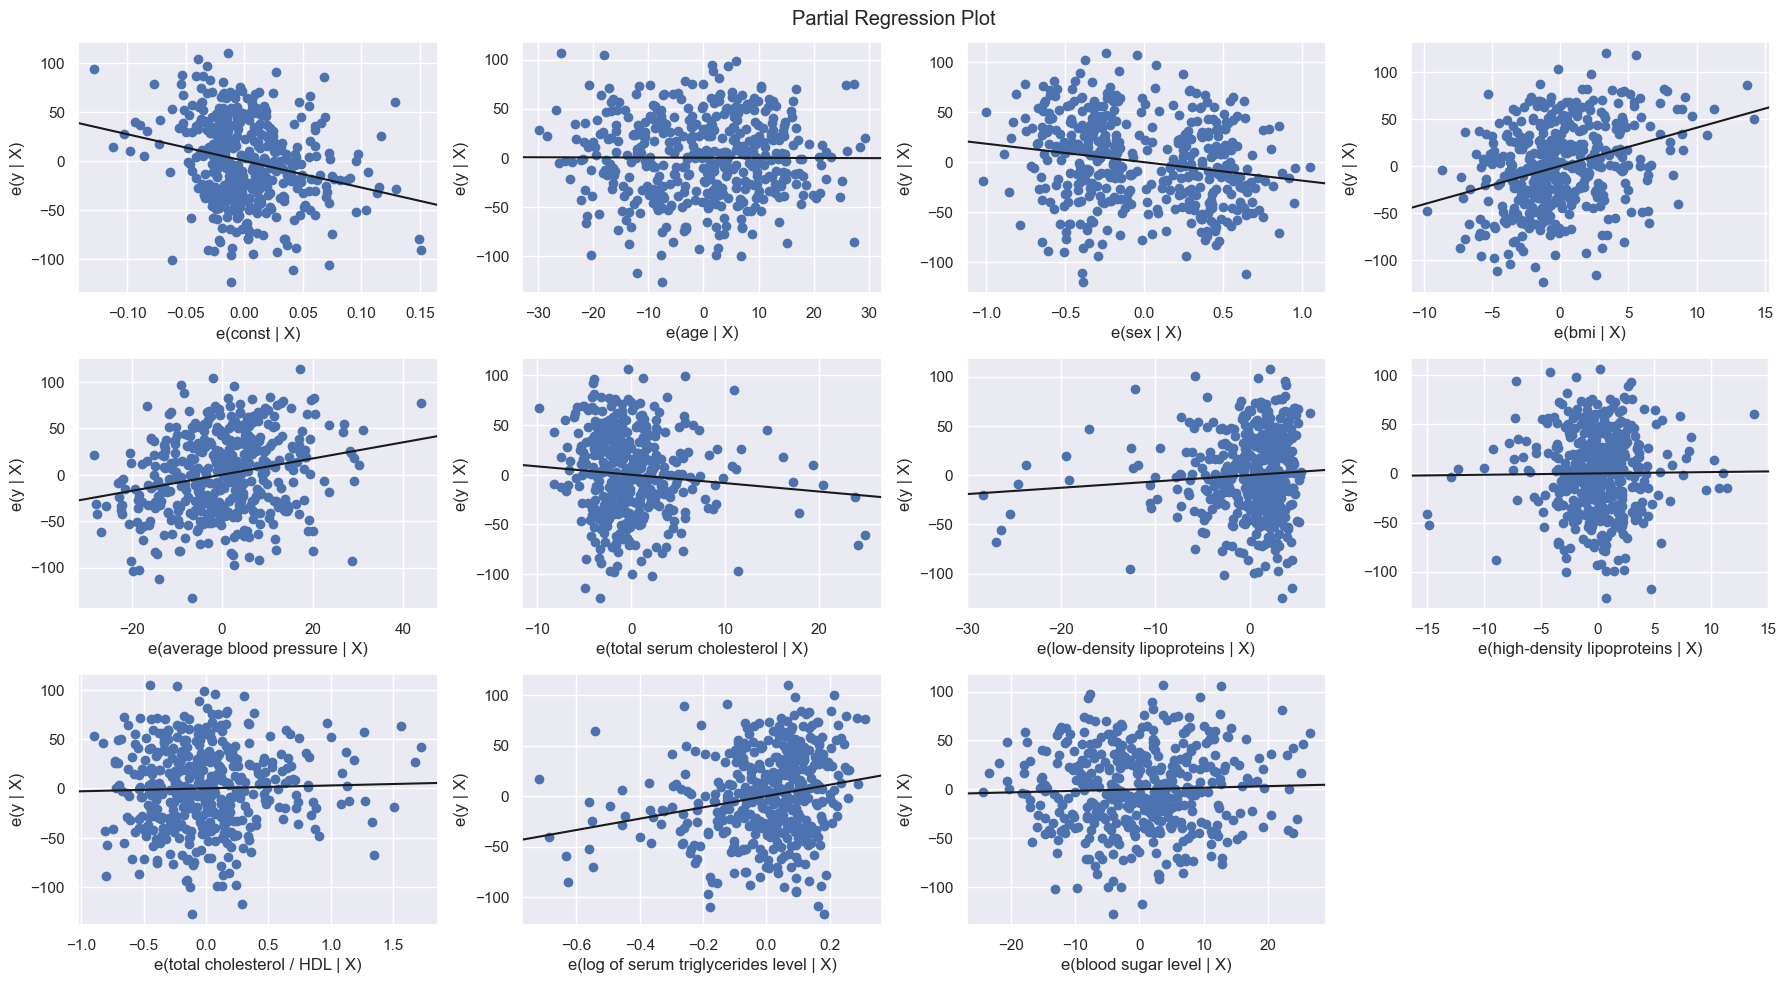

In [74]:
fig = plt.figure(figsize=(18,10));
sm.graphics.plot_partregress_grid(model,grid = (3,4) ,fig=fig);
fig.tight_layout(pad=1.0);

# Explainable Boosting Machine (EBM)

$g(y) =  \epsilon + \sum f_i(x_i) + \sum f_{i,j}(x_i,x_j)$

EBM are a generalization of the linear regression that instad of using weights, computes a function to estimage which effect should have the variable depending of its value. 

This functions are estimated aggregating a lot of small decision trees. 


In [131]:
from interpret.glassbox import  ExplainableBoostingRegressor

seed = 1
#ebm = ExplainableBoostingRegressor(interactions=0, random_state=seed)
ebm = ExplainableBoostingRegressor(interactions=5, random_state=seed)
#ebm = ExplainableBoostingRegressor(interactions=[[2,3],[4,5]], random_state=seed)

ebm.fit(X, y)
ebm.score(X,y)

ExplainableBoostingRegressor(interactions=5, random_state=1)

0.6567774890431873

## Explain the Model

EBMs provide two different kinds of explanations: global explanations about the overall model behavior and local explanations about individual predictions from the model.

### Global Explanations: What the model learned overall
Global Explanations are useful for understanding what a model finds important, as well as identifying potential flaws in its decision making or the training data. Let's start by computing and displaying a global explanation:

In [132]:
ebm_global = ebm.explain_global()
print(ebm_global.selector['Name'])

0                                                   age
1                                                   sex
2                                                   bmi
3                                average blood pressure
4                               total serum cholesterol
5                              low-density lipoproteins
6                             high-density lipoproteins
7                               total cholesterol / HDL
8                      log of serum triglycerides level
9                                     blood sugar level
10                                            age & sex
11               age & log of serum triglycerides level
12                        bmi & total cholesterol / HDL
13    total serum cholesterol & log of serum triglyc...
14    log of serum triglycerides level & blood sugar...
Name: Name, dtype: object


In [133]:
from plotly.offline import iplot
ebm_global = ebm.explain_global()
show(ebm.explain_global(name='EBM'))

<!-- http://127.0.0.1:7026/11014083408/ -->

The overall importance for each term is calculated as _the average absolute contribution (score) a term (feature or pair) makes when predicting across the training dataset._ This way of measuring term importance tends to favor terms which, on average, have large impact on predictions for many cases. The overall importance is not a measure of positive/negative -- it is a measure of how important each term is in the scores. For regression, these scores are represented in the same units as the y-axis of the feature graphs. For classification, the scores would be in logits.

Going beyond overall term importances, because EBMs are additive models we can measure exactly how each term contributes to a prediction. Let's take a look at the graph of the term, `bp`, by selecting it in the drop-down menu.

The way to interpret this is that if a new datapoint came in with `bp` = 0.1, the model adds about +33.1 to the final prediction. However, for a different datapoint with `bp` = 0.13, the model would now add approx. +36.7 to the prediction.

To make individual predictions, the model uses each term graph as a look up table, notes the contribution per term, and sums them together with the learned intercept to make a prediction. In regression, the intercept is the mean target (label) of the training set, and each term adds or subtracts to this mean. In classification, the intercept reflects the base rate of the positive class on a log scale. The gray above and below the graph shows the confidence of the model in that region of the graph.

### EBMs are glassbox models, so we can edit them

In [78]:
# post-process monotonize the age feature
ebm.monotonize("age", increasing=True)
ebm.score(X,y)

ExplainableBoostingRegressor(interactions=5, random_state=1)

0.6491665853804993

In [79]:
ebm_global.selector
for feature_idx in range(len(ebm_global.selector['Name'])):
    iplot(ebm_global.visualize(feature_idx))

,Name,Type,# Unique,% Non-zero
0,age,continuous,58.000,NaN
1,sex,categorical,2.000,NaN
2,bmi,continuous,163.000,NaN
3,average blood pressure,continuous,100.000,NaN
4,total serum cholesterol,continuous,141.000,NaN
5,low-density lipoproteins,continuous,302.000,NaN
6,high-density lipoproteins,continuous,63.000,NaN
7,total cholesterol / HDL,continuous,66.000,NaN
8,log of serum triglycerides level,continuous,184.000,NaN
9,blood sugar level,continuous,56.000,NaN


In [80]:
def clean_name(name):
    return name.replace('/','-').strip().replace(' ','_')

for key in range(len(ebm_global.selector)):
    variable = clean_name(ebm_global.selector.loc[key,'Name'])
    iplot(ebm_global.visualize(key))

### Local Explanations: How an individual prediction was made

We can see the full breakdown of a prediction on a single sample with Local Explanations. Here's how to compute the prediction breakdown for the first sample in our dataset:

In [81]:
ebm_local = ebm.explain_local(X[:5], y[:5])
ebm_local.selector

,Actual,Predicted,Resid,AbsResid
0,101.000,138.669,-37.669,37.669
1,35.000,35.078,-0.078,0.078
2,92.000,123.792,-31.792,31.792
3,145.000,129.901,15.099,15.099
4,86.000,65.640,20.360,20.360


In [82]:
for key in range(len(ebm_local.selector)):
    iplot(ebm_local.visualize(key))

In [83]:
show(ebm_local)

<!-- http://127.0.0.1:7026/11135215184/ -->

Let's take a look at the prediction by selecting it in the drop-down menu.

The model prediction is 188.50. We can see that the intercept adds about +151.3, `sex` subtracts about 6.19, and `age` adds about 4.39. If we repeat this process for all the terms, we'll arrive exactly at the model prediction of 197.

## Viewing _all_ term importances

Due to space limitations in our graphs, the term importance summary only shows the top 15 terms. To view the overall importances of all terms of a trained EBM - the scores shown in the global explanation summary - we use `term_importances()`:

In [84]:
importances = ebm.term_importances()
names = ebm.term_names_

for (term_name, importance) in zip(names, importances):
    print(f"Term {term_name} importance: {importance}")

Term age importance: 2.6412873670339616
Term sex importance: 4.825143417588117
Term bmi importance: 12.613666466995856
Term average blood pressure importance: 7.301904570265803
Term total serum cholesterol importance: 1.4572996205674589
Term low-density lipoproteins importance: 2.524238934157062
Term high-density lipoproteins importance: 6.19931133628852
Term total cholesterol / HDL importance: 5.379965829793666
Term log of serum triglycerides level importance: 12.3090076782667
Term blood sugar level importance: 4.520098895736426
Term age & sex importance: 1.593152952798219
Term age & log of serum triglycerides level importance: 1.5986109586972108
Term bmi & total cholesterol / HDL importance: 1.9650976813544663
Term total serum cholesterol & log of serum triglycerides level importance: 1.5054935619247483
Term log of serum triglycerides level & blood sugar level importance: 1.9002212438931902


Note that mean absolute contribution isn't the only way of calculating term importances. Another metric interpret package provides is the `min_max` option, which computes the difference between the `max` (the highest score on the graph) and `min` (the lowest score on the graph) values for each term. Term importance measured with `min_max` is a measure of the maximum impact a term can have, even though it might have this amount of impact on very few cases, whereas `avg_weight`(the default parameter) is a measure of typical (average) contribution of a term across all cases.

## Evaluate EBM performance

In [85]:
importances = ebm.term_importances("min_max")
names = ebm.term_names_

for (term, importance) in zip(names, importances):
    print(f"Term {term} importance: {importance}")

Term age importance: 10.790457134383939
Term sex importance: 9.689169684794788
Term bmi importance: 54.62330958920809
Term average blood pressure importance: 37.48910129470053
Term total serum cholesterol importance: 8.965274040427165
Term low-density lipoproteins importance: 21.7668323814565
Term high-density lipoproteins importance: 28.59559779316383
Term total cholesterol / HDL importance: 25.91721226006639
Term log of serum triglycerides level importance: 36.92493786566504
Term blood sugar level importance: 26.03849405933574
Term age & sex importance: 12.286008338039746
Term age & log of serum triglycerides level importance: 6.74719509460922
Term bmi & total cholesterol / HDL importance: 7.768335388379313
Term total serum cholesterol & log of serum triglycerides level importance: 12.78924616052495
Term log of serum triglycerides level & blood sugar level importance: 16.65177376268459


In [86]:
ebm_perf = RegressionPerf(ebm).explain_perf(X_test, y_test, name='EBM')
show(ebm_perf)

<!-- http://127.0.0.1:7026/11134021776/ -->

# Let's test out a few other Explainable Models

In [87]:
X, y = load_diabetes(return_X_y=True, scaled= False, as_frame=True)

seed = 42
np.random.seed(seed)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=seed)
X.sex.value_counts()

sex
1.000    235
2.000    207
Name: count, dtype: int64

In [88]:
from interpret.glassbox import LinearRegression, RegressionTree

lr = LinearRegression()
lr.fit(X_train, y_train)

rt = RegressionTree(random_state=seed)
rt.fit(X_train, y_train)

In [89]:
lr_perf = RegressionPerf(lr).explain_perf(X_test, y_test, name='Linear Regression')
show(lr_perf)

<!-- http://127.0.0.1:7026/11134588432/ -->

In [90]:
rt_perf = RegressionPerf(rt).explain_perf(X_test, y_test, name='Regression Tree')
show(rt_perf)

<!-- http://127.0.0.1:7026/11135086416/ -->

## Glassbox: All of our models have global and local explanations

In [91]:
lr_global = lr.explain_global(name='Linear Regression')
show(lr_global)

<!-- http://127.0.0.1:7026/11135619600/ -->

In [92]:
lr_local = lr.explain_local(X_test[:5], y_test[:5], name='Linear Regression')
show(lr_local)

<!-- http://127.0.0.1:7026/11135786064/ -->

In [93]:
rt_global = rt.explain_global(name='Regression Tree')
show(rt_global)

<!-- http://127.0.0.1:7026/11462329872/ -->

In [94]:
rt_local = rt.explain_local(X_test[:5], y_test[:5], name='Regression Tree')
show(rt_local)

<!-- http://127.0.0.1:7026/11134781840/ -->

# Compare performance using the Dashboard
## Look at everything at once

In [95]:
# Do everything in one shot with the InterpretML Dashboard by passing a list into show

show([marginal, lr_perf, rt_perf, lr_global, rt_global, lr_local, rt_local, ebm_local, ebm_global, ebm_perf])

<!-- http://127.0.0.1:7026/11135620736/ -->
 Open in new window

# Setup a classification experiment with EBM

## The ADULT dataset

ADULT dataset Description

Author: Ronny Kohavi and Barry Becker

Source: https://www.openml.org/search?type=data&sort=runs&id=1590&status=active

Please cite: Ron Kohavi, "Scaling Up the Accuracy of Naive-Bayes Classifiers: a Decision-Tree Hybrid", Proceedings of the Second International Conference on Knowledge Discovery and Data Mining, 1996

Prediction task is to determine whether a person makes over 50K a year. Extraction was done by Barry Becker from the 1994 Census database. A set of reasonably clean records was extracted using the following conditions: ((AAGE>16) && (AGI>100) && (AFNLWGT>1)&& (HRSWK>0))

This is the original version from the UCI repository, with training and test sets merged.
Variable description

Variables are all self-explanatory except fnlwgt. This is a proxy for the demographic background of the people: "People with similar demographic characteristics should have similar weights". This similarity-statement is not transferable across the 51 different states.

Description from the donor of the database:

The weights on the CPS files are controlled to independent estimates of the civilian noninstitutional population of the US. These are prepared monthly for us by Population Division here at the Census Bureau. We use 3 sets of controls. These are:

    A single cell estimate of the population 16+ for each state.
    Controls for Hispanic Origin by age and sex.
    Controls by Race, age and sex.

We use all three sets of controls in our weighting program and "rake" through them 6 times so that by the end we come back to all the controls we used. The term estimate refers to population totals derived from CPS by creating "weighted tallies" of any specified socio-economic characteristics of the population. People with similar demographic characteristics should have similar weights. There is one important caveat to remember about this statement. That is that since the CPS sample is actually a collection of 51 state samples, each with its own probability of selection, the statement only applies within state.
Relevant papers

Ronny Kohavi and Barry Becker. Data Mining and Visualization, Silicon Graphics.
e-mail: ronnyk '@' live.com for questions.

We are dropping the following features:

- "fnlwgt": this feature was created while studying the "adult" dataset.
  Thus, we will not use this feature which is not acquired during the survey.
- "education-num": it is encoding the same information than "education".
  Thus, we are removing one of these 2 features.



In [96]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from interpret import show
from interpret.perf import ROC

df = pd.read_csv(
    "../../data/adult.data",
    header=None)
df.columns = [
    "Age", "WorkClass", "fnlwgt", "Education", "EducationNum",
    "MaritalStatus", "Occupation", "Relationship", "Race", "Gender",
    "CapitalGain", "CapitalLoss", "HoursPerWeek", "NativeCountry", "Income"
]

df = df.drop(columns=["fnlwgt", "EducationNum"])

X = df.iloc[:, :-1]
y = (df.iloc[:, -1] == " >50K").astype(int)

seed = 42
np.random.seed(seed)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=seed)

## Explore the dataset

In [97]:
from interpret.data import ClassHistogram

hist = ClassHistogram().explain_data(X_train, y_train, name='Train Data')
show(hist)


<!-- http://127.0.0.1:7026/11134339984/ -->

## Train the Explainable Boosting Machine Classifier

In [98]:
from interpret.glassbox import ExplainableBoostingClassifier

ebm = ExplainableBoostingClassifier()
ebm.fit(X_train, y_train)

ExplainableBoostingClassifier()

### Confusion Matrix

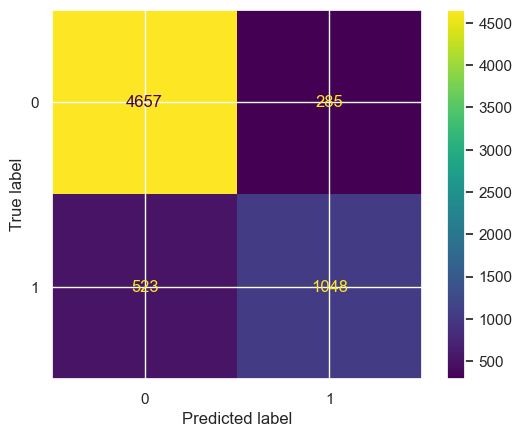

In [99]:
predictions = ebm.predict(X_test)
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ebm.classes_)
disp.plot()
plt.show()

### EBMs are glassbox models, so we can edit them

ExplainableBoostingClassifier()

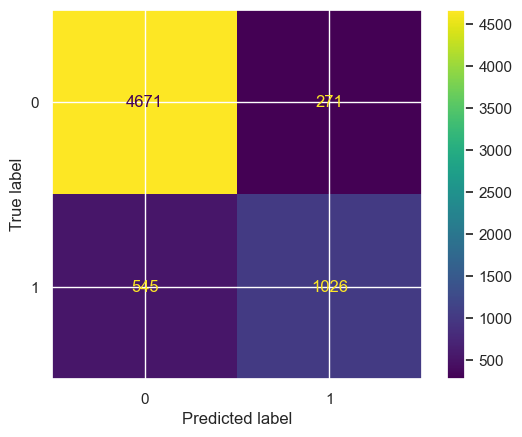

In [100]:
# post-process monotonize the Age feature
ebm.monotonize("Age", increasing=True)
predictions = ebm.predict(X_test)
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ebm.classes_)
disp.plot()
plt.show()

### Global Explanations: What the model learned overall

In [101]:
ebm_global = ebm.explain_global(name='EBM')
show(ebm_global)

<!-- http://127.0.0.1:7026/11462631120/ -->

### Local Explanations: How an individual prediction was made

In [102]:
ebm_local = ebm.explain_local(X_test[:5], y_test[:5], name='EBM')
show(ebm_local, 0)

<!-- http://127.0.0.1:7026/11130055504/ -->

### Evaluate EBM performance

In [103]:
ebm_perf = ROC(ebm).explain_perf(X_test, y_test, name='EBM')
show(ebm_perf)

<!-- http://127.0.0.1:7026/11451478160/ -->

# PLAYTIME: Study the titanic dataset

<div class="alert alert-success">
PLAYTIME: Decide on the task (classification/regression) and train the corresponding EBM to use on the titanic dataset. Remember to look at the feature distribution and perform some processing. Check the types of variables do we have (categorical, numerical). Which is the most important attribute/feature for predicting survival? Plot out the global and local explanations. Plot out the confusion matrix and term importances.
</div>


RMS Titanic was a British passenger liner, operated by the White Star Line, which sank in the North Atlantic Ocean on 15 April 1912 after striking an iceberg during her maiden voyage from Southampton, UK, to New York City, United States. Of the estimated 2,224 passengers and crew aboard, more than 1,500 died, making it the deadliest sinking of a single ship up to that time. It remains the deadliest peacetime sinking of a superliner or cruise ship.

In [106]:
titanic = pd.read_csv('../../data/titanic/titanic_train.csv')

In [107]:
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000,1,0,A/5 21171,7.250,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,71.283,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000,0,0,STON/O2. 3101282,7.925,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,113803,53.100,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.000,0,0,373450,8.050,NaN,S


In [108]:
titanic.shape

(891, 12)

In [109]:
titanic.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000,891.000,891.000,714.000,891.000,891.000,891.000
mean,446.000,0.384,2.309,29.699,0.523,0.382,32.204
std,257.354,0.487,0.836,14.526,1.103,0.806,49.693
min,1.000,0.000,1.000,0.420,0.000,0.000,0.000
25%,223.500,0.000,2.000,20.125,0.000,0.000,7.910
50%,446.000,0.000,3.000,28.000,0.000,0.000,14.454
75%,668.500,1.000,3.000,38.000,1.000,0.000,31.000
max,891.000,1.000,3.000,80.000,8.000,6.000,512.329


Note some interesting statistics. The average survival rate was 38%. Ages range from 5 months up until 80 years, with the average age being about 30. The minimum fare paid was 0, which makes sense for important passengers such as owners and engineers.

Did the oldest person on the ship survive? Heck yes!


In [110]:
titanic[titanic['Age']==80]
Algernon_Henry_Wilson_Barkworth = titanic.iloc[630,:]
Algernon_Henry_Wilson_Barkworth

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
630,631,1,1,"Barkworth, Mr. Algernon Henry Wilson",male,80.000,0,0,27042,30.000,A23,S


PassengerId                                     631
Survived                                          1
Pclass                                            1
Name           Barkworth, Mr. Algernon Henry Wilson
Sex                                            male
Age                                          80.000
SibSp                                             0
Parch                                             0
Ticket                                        27042
Fare                                         30.000
Cabin                                           A23
Embarked                                          S
Name: 630, dtype: object

In [111]:
titanic.groupby(['Sex', 'Pclass'])['Survived'].mean() * 100

Sex     Pclass
female  1        96.809
        2        92.105
        3        50.000
male    1        36.885
        2        15.741
        3        13.545
Name: Survived, dtype: float64

<Axes: xlabel='Age', ylabel='Density'>

<Axes: xlabel='Age', ylabel='Density'>

Text(0.5, 1.0, 'Age distribution among survival classes')

Text(0, 0.5, 'Frequency')

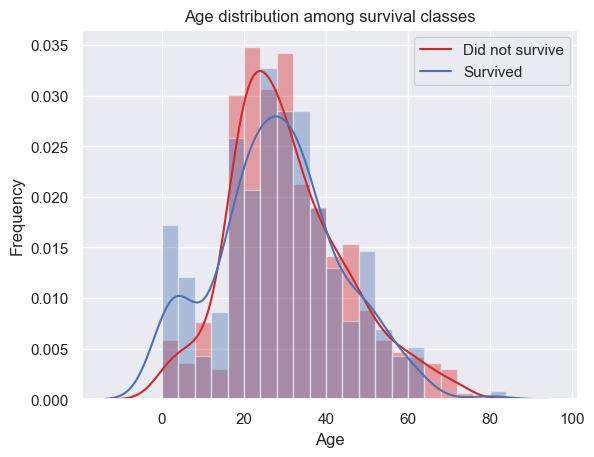

In [112]:
import matplotlib.pyplot as plt
import seaborn as sns
age_bins = np.arange(0, 100, 4)
sns.distplot(titanic.loc[(titanic['Survived']==0) & (~titanic['Age'].isnull()),'Age'], bins=age_bins, color='#d62728')
sns.distplot(titanic.loc[(titanic['Survived']==1) & (~titanic['Age'].isnull()),'Age'], bins=age_bins)
plt.title('Age distribution among survival classes')
plt.ylabel('Frequency')
plt.legend(['Did not survive', 'Survived'])
plt.show()

### Complementary readings:
[The Explainable Boosting Machine](https://towardsdatascience.com/the-explainable-boosting-machine-f24152509ebb)

[Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/)